# How to Use Pairwise Correlation For Robust Feature Selection
## TODO
<img src='images/pexels.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@pixabay?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pixabay</a>
        on 
        <a href='https://www.pexels.com/photo/2-grey-and-black-birds-45853/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### What Is Correlation Coefficient?

In my [last article](https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f?source=your_stories_page-------------------------------------) on the topic of Feature Selection, we focused on a technique to remove features based on their individual properties. In this post, we will look at a more reliable, more robust method which let's us see the connection between features and decide if they are worth keeping. This method, as you have read from the title, uses Pairwise Correlation.

First of all, let's briefly touch on the Pearson's correlation coefficient - commonly denoted as *r*. This coefficient can be used to quantify the linear relationship between two distributions (or features) in a single metric. It ranges from -1 to 1, -1 being a perfect negative correlation and 1 being perfect positive correlation.

<img src='https://miro.medium.com/proxy/1*8neIel7ZpzIc3p64f04-NQ.png'></img>

For instance, body measurements often have strong positive correlation. You can expect someone tall to have longer arms and legs or someone with broad shoulders to weigh more. Also, the sales of ice cream is negatively correlated with temperature or the further you run the slower you get, etc.

> For an in-depth guide on how to use, interpret and understand correlation coefficient, refer to my separate [article](https://towardsdev.com/how-to-not-misunderstand-correlation-75ce9b0289e).

But what does correlation coefficient have to do with Machine Learning or feature selection? Well, let's say the correlation coefficient between two features is 0.85. This high values means that in 85% of the time, you can predict feature 2 just using the values of feature 1. In other words, if you have feature 1 in your dataset, feature 2 won't bring much new information. That's why there is no point in keeping feature 2 since it only adds to complexity when training a model.

Using pairwise correlation for feature selection is all about that - identifying groups of highly-correlated features and only keeping one of them so that your model can have as much predictive power using as few features as possible.

### Plotting the Perfect Correlation Matrix

The quickest and often the best method of identifying highly-correlated features is to use a correlation matrix. This matrix shows the correlation between every single pair of numeric features in the dataset. 

Let's see one using the Melbourne Housing dataset which contains 13 numeric features:

In [9]:
houses = pd.read_csv('data/melb_data.csv')
houses.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Calculating the matrix is easily done by calling the `.corr()` method on the DataFrame. Next, we pass it to Seaborn's heatmap function which is commonly done to generate a nice visual:

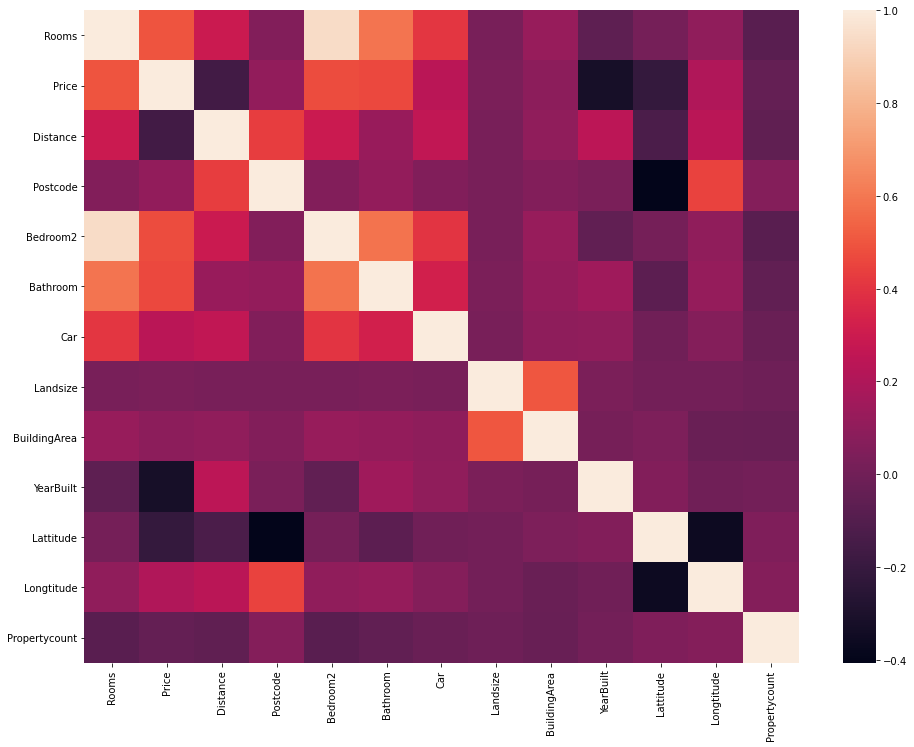

In [10]:
matrix = houses.corr()

plt.figure(figsize=(16,12))

_ = sns.heatmap(matrix)

Yeah, the default heatmap is not so great. Let's give it a make-up:

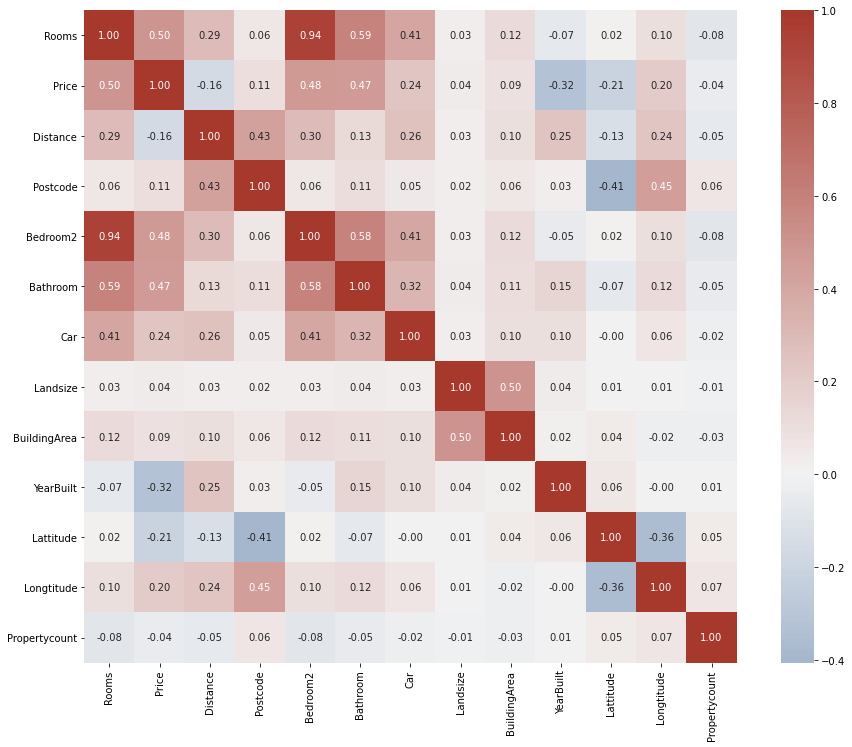

In [14]:
plt.figure(figsize=(16,12))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

_ = sns.heatmap(matrix, center=0, annot=True, fmt='.2f', square=True, cmap=cmap)

First, we create a custom diverging palette (blue -> white ->  red). Then, we center the colorbar around 0, enable the annotations to see each correlation and using 2 decimal points.

As you see, the matrix shows each correlation between pairs twice since correlation between A and B is the same as the correlation between B and A. Also, the diagonal consists of only 1s representing correlation of features with themselves. All this extra information can be distracting. That's why, let's get rid of the upper part of the matrix:

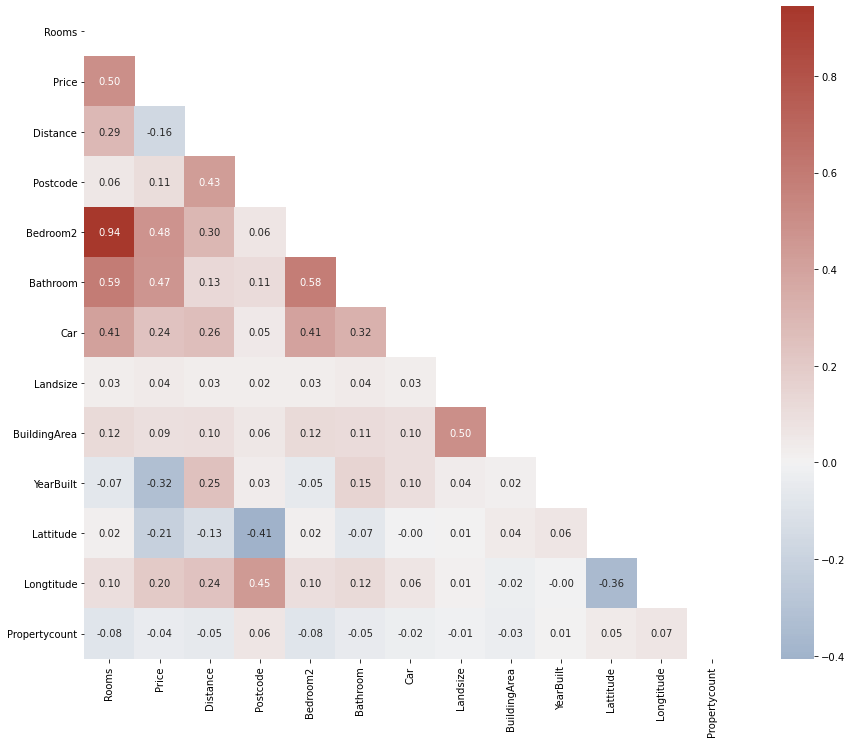

In [17]:
# Create a mask
plt.figure(figsize=(16,12))

mask = np.triu(np.ones_like(matrix, dtype=bool))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

In line 4 of the above code snippet, we create a 2D boolean mask. First, `np.ones_like` creates a 2D numpy array with the same shape as our correlation matrix filled with `True` values. Then, passing this array to `np.triu` converts it to a boolean mask suited to our needs. We just pass this mask to `heatmap`'s `mask` argument which gives us the beautiful plot above. 

Here is a small function to create these perfect correlation matrices:

In [19]:
def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

Even though, we could just find out all the highly-correlated features programmatically, we should still visually explore them. Because, a heatmap like above helps us see if the correlations makes sense. For example, the number of new-born babies can be highly correlated with the number of storks in the vicinity even though that does not make any sense. That's why, do visual exploration to see if groups of features are actually related to each other and whether it makes sense to look for a connection between them.

### How to Remove Highly Correlated Features

Now, let's see how we can actually remove highly-correlated features. We will use a different dataset this time - Ansur Dataset. It contains every imaginable body measurement of 6000 US Army personnel and it contains 98 numeric features. It is an excellent dataset to practice your feature selection skills since there are many correlated features in this dataset:

In [ ]:
ansur = pd.read_csv('data/')